In [1]:
from dataset import DataLoader, DataVisualizer, DatasetBuilder
#from models import *
import tensorflow as tf
from utils.input import *

In [2]:
data = DataLoader(path='DATA/speech_commands_v0.02')

Dataset path:  DATA/speech_commands_v0.02


In [3]:
commands = data.get_commands()
commands

array(['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed',
       'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left',
       'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up',
       'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on',
       'five', 'forward', 'off', 'four'], dtype='<U19')

In [4]:
filenames = data.get_filenames()

In [5]:
train_files, val_files, test_files = data.split_data(filenames)

In [6]:
val_files

<tf.Tensor: shape=(5291,), dtype=string, numpy=
array([b'DATA/speech_commands_v0.02/sheila/4f256313_nohash_1.wav',
       b'DATA/speech_commands_v0.02/on/e11fbc6e_nohash_0.wav',
       b'DATA/speech_commands_v0.02/go/f035e2ea_nohash_3.wav', ...,
       b'DATA/speech_commands_v0.02/sheila/e9323bd9_nohash_1.wav',
       b'DATA/speech_commands_v0.02/four/5efb758c_nohash_1.wav',
       b'DATA/speech_commands_v0.02/sheila/38c30a4a_nohash_0.wav'],
      dtype=object)>

In [7]:
commands

array(['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed',
       'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left',
       'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up',
       'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on',
       'five', 'forward', 'off', 'four'], dtype='<U19')

In [8]:
data.get_waveform_ds(test_files)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
ds = DatasetBuilder(
    commands=commands,
    train_filenames=train_files,
    val_filenames=val_files,
    test_filenames=test_files,
    batch_size=64,
    buffer_size=1000,
    method='STFT',
)


In [10]:
ds

In [11]:
train, test, val = ds.preprocess_dataset_spectrogram()

In [12]:
train_waveforms = data.get_waveform_ds(train_files)

In [13]:
for waveform, label in train_waveforms.take(1):
  print("Waveform shape: ", waveform.numpy().shape)
  print("Label: ", label.numpy())
  prova = waveform.numpy()

Waveform shape:  (16000,)
Label:  b'four'


In [14]:
# Take only the first 5 elements
subset_dataset = train_waveforms.take(1)

subset_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [15]:
train_waveforms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

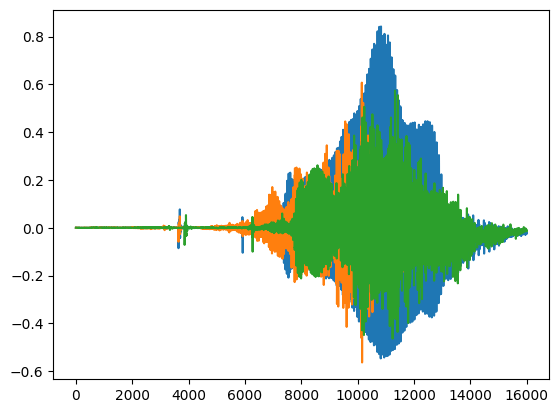

In [16]:
from utils.augment import pitch_shift, time_stretch
import matplotlib.pyplot as plt
time_stretched = train_waveforms.map(
    lambda waveform, label: (time_stretch(waveform), label)
)
pitch_shifted = train_waveforms.map(
    lambda waveform, label: (pitch_shift(waveform), label)
)

for waveform, label in train_waveforms.take(1):
    plt.plot(waveform.numpy())
    

for waveform, label in time_stretched.take(1):
    plt.plot(waveform.numpy())
    
for waveform, label in pitch_shifted.take(1):
    plt.plot(waveform.numpy())

In [17]:
from IPython import display

for waveform, label in train_waveforms.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))

for waveform, label in pitch_shifted.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))
    
for waveform, label in time_stretched.take(2):
    label = label.numpy().decode('utf-8')
    
    
    # Plot the waveform
    display.display(display.Audio(waveform, rate=16000))

In [18]:
spectrograms = data.get_spectrogram_STFT_ds(
    train_waveforms,
    commands
)


for spec, label in spectrograms.take(1):
    print("Spectrogram shape: ", spec.numpy().shape)
    print("Label: ", label.numpy())

Spectrogram shape:  (257, 98, 1)
Label:  34


In [19]:
from utils.augment import time_mask, freq_mask, time_freq_mask, time_warp

time_masked = spectrograms.map(
    lambda spec, label: (time_mask(spec), label)
)
freq_masked = spectrograms.map(
    lambda spec, label: (freq_mask(spec), label)
)
time_freq_masked = spectrograms.map(
    lambda spec, label: (time_freq_mask(spec), label)
)
time_warped = spectrograms.map(
    lambda spec, label: (time_warp(spec), label)
)

In [20]:
spectrograms.skip(1).take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(257, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [21]:
time_masked.skip(1).take(1)


<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

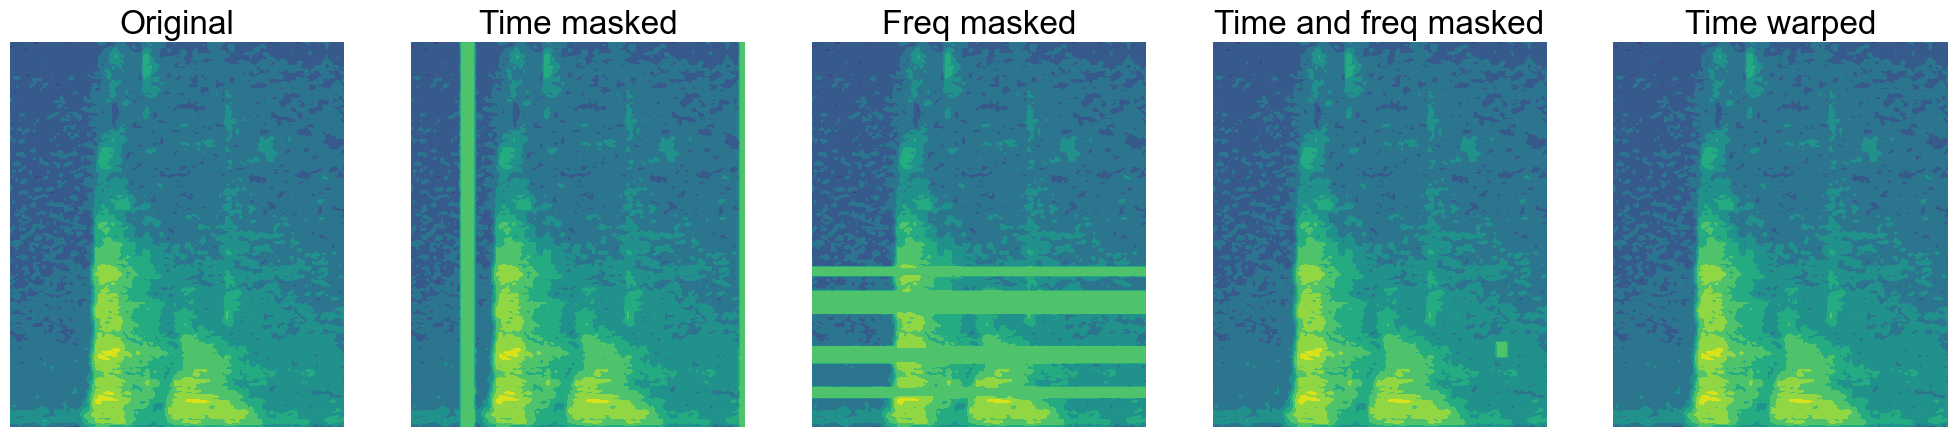

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
import seaborn as sns
sns.set_theme(font_scale=2)
for spec, label in spectrograms.skip(1).take(1):
    ax[0].contourf(
        spec.numpy()[:, :, 0],
        cmap='viridis',
        origin='lower'
    )
    ax[0].set_title('Original')
    ax[0].axis('off')
    
for spec, label in time_masked.skip(1).take(1):
    ax[1].contourf(
        spec.numpy()[:, :, 0],
        cmap='viridis',
        origin='lower'
    )
    ax[1].set_title('Time masked')
    ax[1].axis('off')
    
for spec, label in freq_masked.skip(1).take(1):
    ax[2].contourf(
        spec.numpy()[:, :, 0],
        cmap='viridis',
        origin='lower'
    )
    ax[2].set_title('Freq masked')
    ax[2].axis('off')

for spec, label in time_freq_masked.skip(1).take(1):
    ax[3].contourf(
        spec.numpy()[:, :, 0],
        cmap='viridis',
        origin='lower'
    )
    ax[3].set_title('Time and freq masked')
    ax[3].axis('off')

for spec, label in time_warped.skip(1).take(1):
    ax[4].contourf(
        spec.numpy()[:, :, 0],
        cmap='viridis',
        origin='lower'
    )
    ax[4].set_title('Time warped')
    ax[4].axis('off')

fig.savefig('figures/augmentations.pdf', dpi=300, bbox_inches='tight')

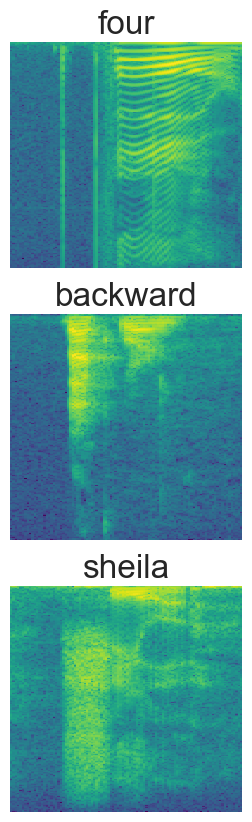

<Figure size 640x480 with 0 Axes>

In [23]:
visual = DataVisualizer(train_waveforms, time_warped, commands)
visual.plot_spectrogram_example(rows=3, cols=1, figsize=(3,10), savefig=True, filename='spectrogram_example.pdf')


In [24]:
for spectrogram, _ in spectrograms.take(1):
    print(spectrogram.numpy().shape)
    print(visual.commands[_.numpy()])

(257, 98, 1)
four


In [25]:
train_spectrograms = data.get_spectrogram_logmel_ds(
    train_waveforms,
    commands
)
train_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(40, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
mfcc_spectrograms = data.get_spectrogram_mfcc_ds(
    train_waveforms,
    commands
)
mfcc_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(13, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())

Spectrogram shape:  (40, 98)
Label:  34


In [28]:
from dataset import DataVisualizer
visual = DataVisualizer(train_waveforms, train_spectrograms, commands)

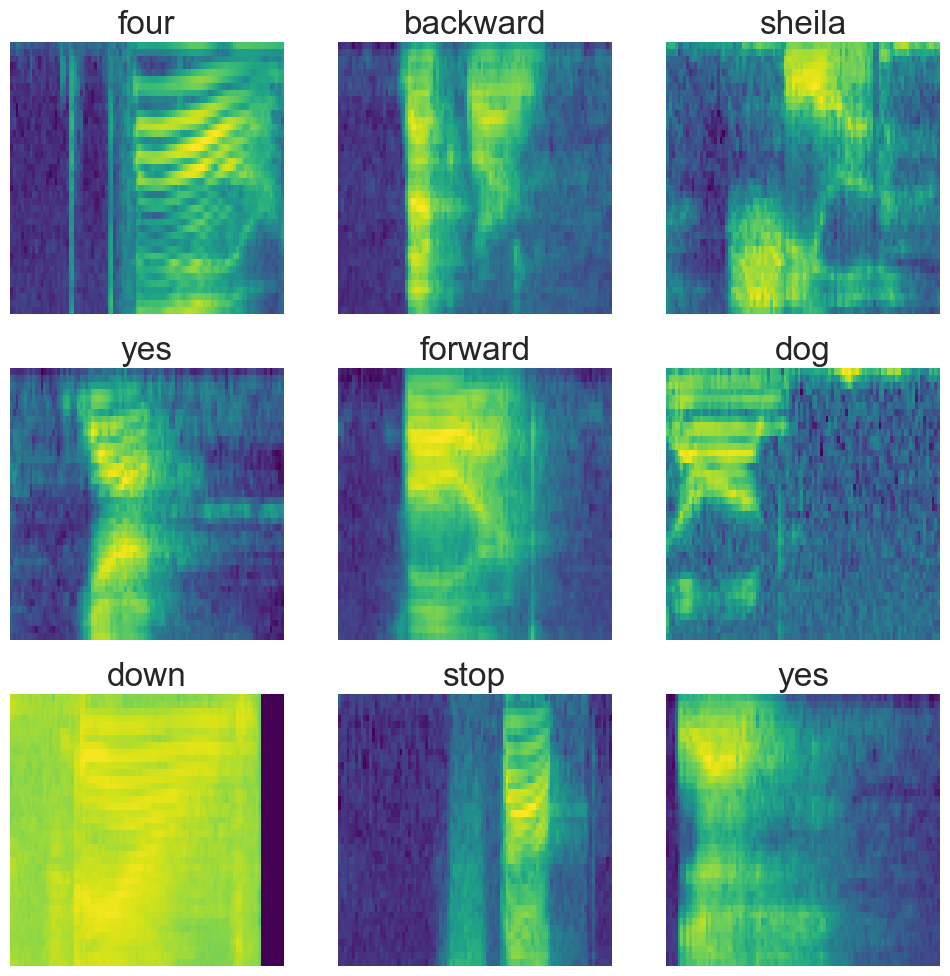

In [29]:
visual.plot_spectrogram_example()

In [30]:
from utils.plot import plot_features

Spectrogram shape:  (40, 98)
Label:  four


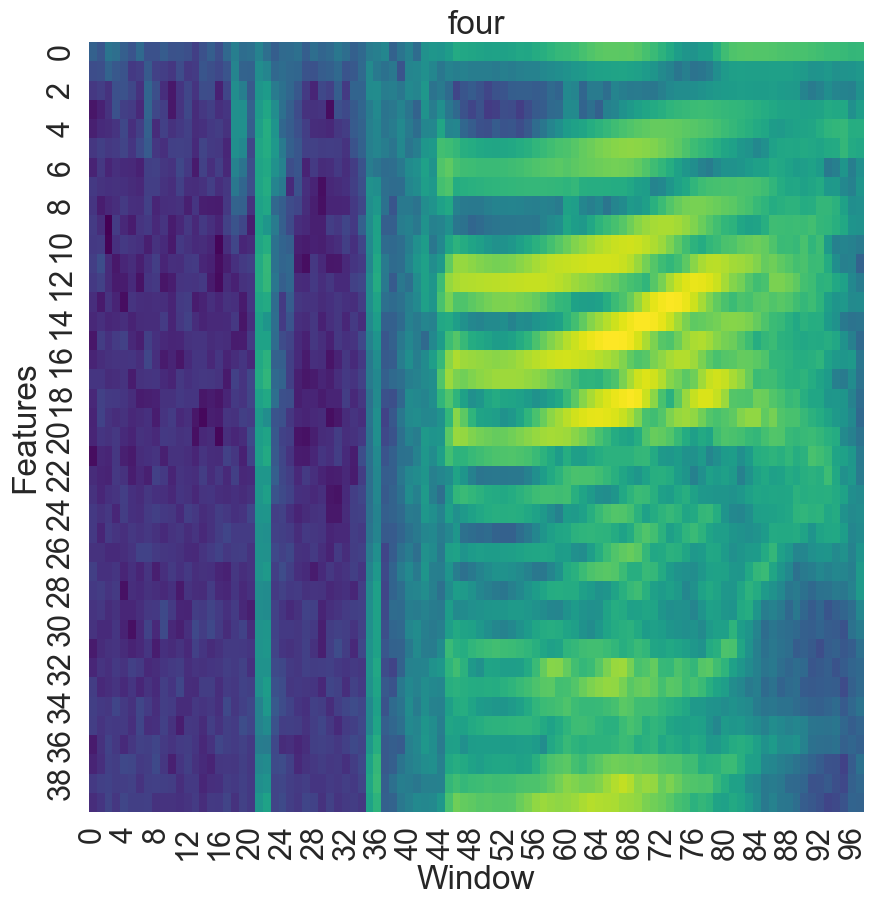

In [31]:
import matplotlib.pyplot as plt

for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  axes.set_title(visual.commands[label.numpy()])

Spectrogram shape:  (13, 98)
Label:  four


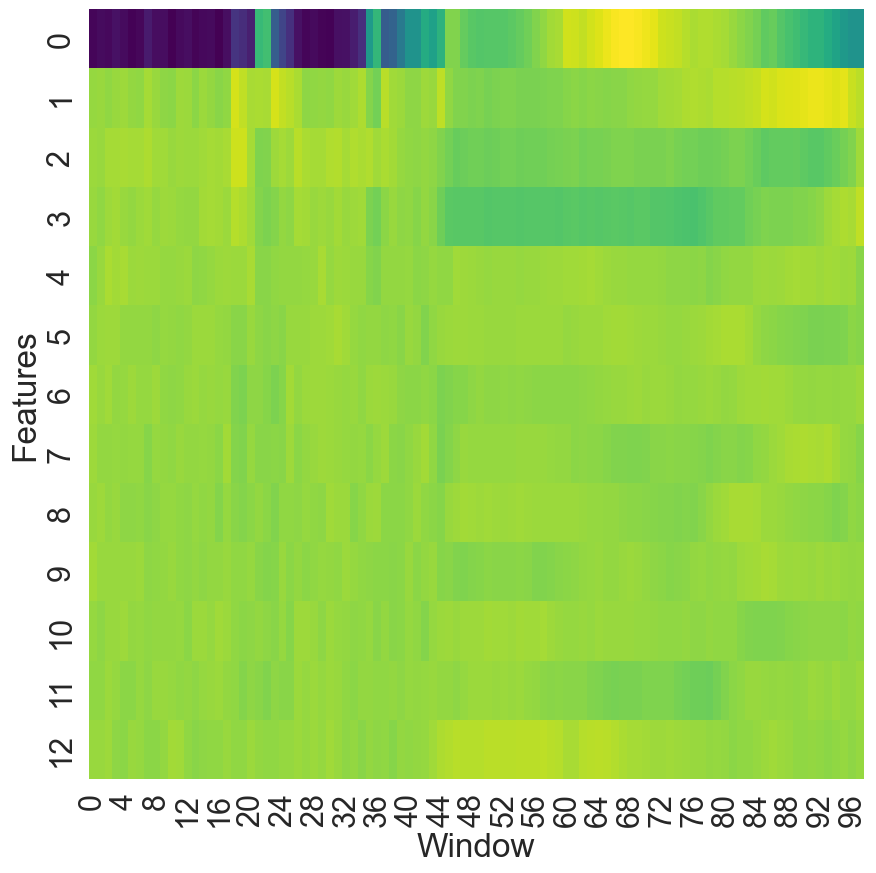

In [32]:
import matplotlib.pyplot as plt
import numpy as np

for i, (spectrogram, label) in enumerate(mfcc_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  plt.show()

Spectrogram shape:  (257, 98, 1)
Label:  34


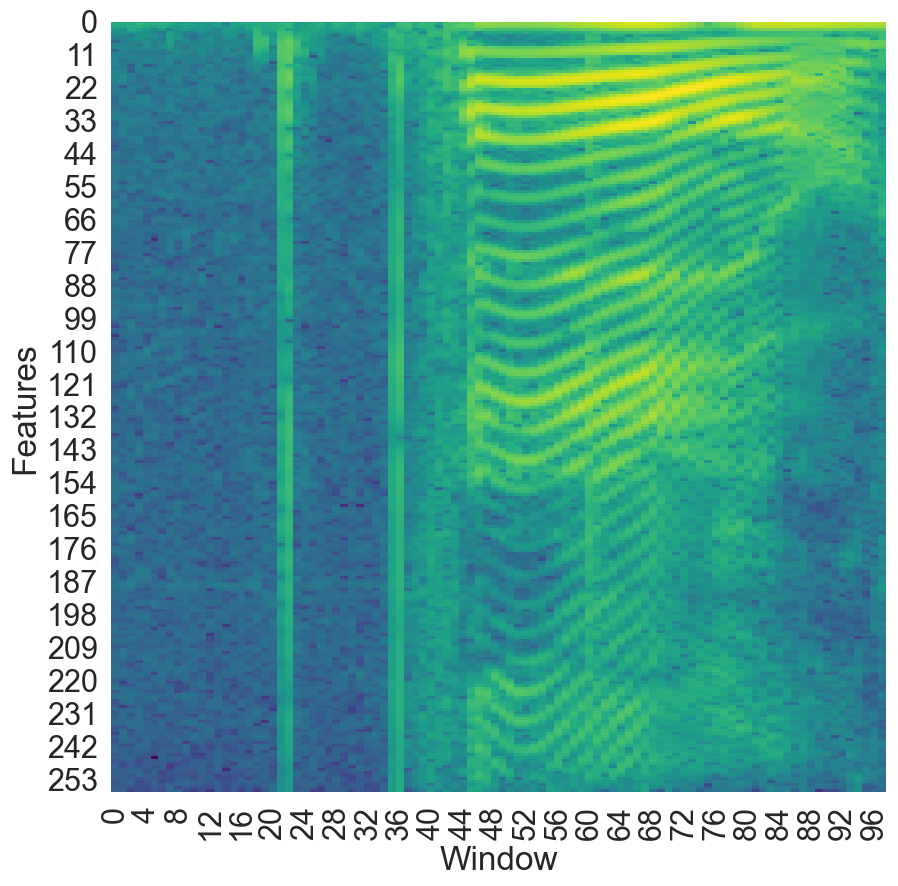

In [33]:
for i, (spectrogram, label) in enumerate(spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [34]:
for i, (spectrogram_batch, label_batch) in enumerate(train.take(1)):
    for spectrogram in spectrogram_batch:
        spectrogram_shape = tf.shape(spectrogram)
        print("Spectrogram shape:", spectrogram_shape)


Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], shape=(4,), dtype=int32)
Spectrogram shape: tf.Tensor([257  98   1   1], sha

2023-06-18 14:47:26.209411: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [35]:
from models import CNNTradFPool3

model = CNNTradFPool3(
    train_ds = train,
    test_ds = test,
    val_ds = val,
    commands = commands,
)
model.define_model()
model.model.summary()

/Users/zattacole/anaconda3/envs/zatta/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-06-18 14:47:26.536699: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: Exception encountered when calling layer "resizing" (type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing" (type Resizing):
  • inputs=tf.Tensor(shape=(None, 257, 98, 1, 1), dtype=float32)

In [ ]:
model.create_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 98)]          0         
                                                                 
 resizing_1 (Resizing)       (32, 32, 98)              0         
                                                                 
 normalization (Normalizati  (32, 32, 98)              3         
 on)                                                             
                                                                 
 tf.expand_dims_1 (TFOpLamb  (32, 32, 98, 1)           0         
 da)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 32, 98, 64)          10304     
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 32, 32, 64)          0   

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import tensorboard

In [ ]:
name_model = 'CNNTradFPool3'

In [ ]:
model_tensorboad_callback = TensorBoard(log_dir="logs/{}".format(name_model))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
history = model.fit(
    epochs=10,
    callbacks=[model_checkpoint_callback],
    verbose=1,
    return_history=True,)

Epoch 1/10


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1364, in train_function  *
        return step_function(self, iterator)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1348, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1329, in run_step  **
        outputs = model.train_step(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1106, in train_step
        y_pred = self(x, training=True)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_1' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_1' (type Resizing):
      • inputs=tf.Tensor(shape=(40, None), dtype=float32)


In [ ]:
model.input_shape

TensorShape([40, 98])

Spectrogram shape:  (40, 98)
Label:  ()


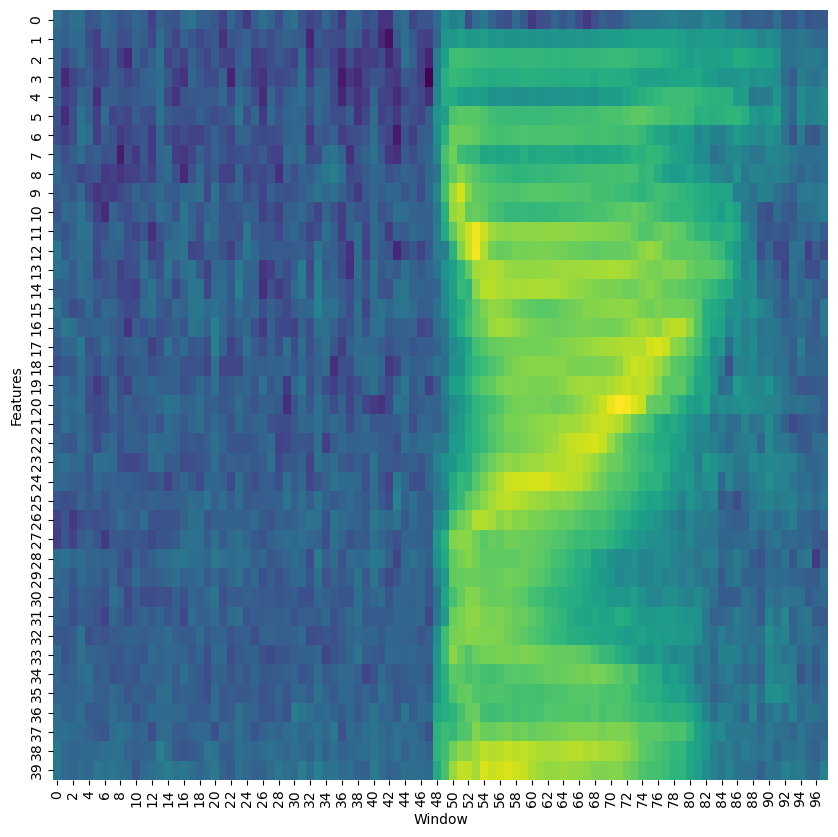

In [ ]:
for i, (spectrogram, label) in enumerate(model.train_ds.take(1)):
  print('Spectrogram shape: ', spectrogram.shape)
  print('Label: ', label.shape)
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [ ]:
model.input_shape

TensorShape([40, 98])

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,\
                                    Flatten, Dense, Input,\
                                    Resizing

input = Input(model.input_shape)

In [ ]:
a = Resizing(32,32)(input)
a = model.norm_layer(a)

In [ ]:
a = tf.expand_dims(a, -1)
a

<KerasTensor: shape=(32, 32, 98, 1) dtype=float32 (created by layer 'tf.expand_dims_2')>

In [ ]:
Conv2D(
    filters=64,
    kernel_size=(20,8),
    activation='relu',
    padding='same',
)(a)

<KerasTensor: shape=(32, 32, 98, 64) dtype=float32 (created by layer 'conv2d_4')>

In [ ]:
a

<KerasTensor: shape=(32, 3136) dtype=float32 (created by layer 'flatten_1')>

In [ ]:
#norm_layer = tf.keras.layers.Normalization(axis=-1)
#
#dummy_input = tf.keras.Input(shape=model.input_shape[1:], name='Input')
#norm_layer.adapt(dummy_input)
#norm_layer

batch_size = 64

norm_layer = tf.keras.layers.Normalization(axis=-1)
# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
dummy_input = tf.zeros(shape=(batch_size,) + model.input_shape[1:])
norm=norm_layer.adapt(data=dummy_input)

norm(tf.zeros(shape=(batch_size,) + model.input_shape[1:]))

TypeError: 'NoneType' object is not callable

In [ ]:
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

2023-06-02 22:39:00.269047: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:39:00.269261: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 295, in _adapt_maybe_build  **
        self.build(data_shape)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/layers/preprocessing/normalization.py", line 188, in build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [40, None], with unknown axis at index: 1


In [ ]:
for spec in train.map(
    map_func = lambda spec, label: spec
).take(1): print(tf.keras.layers.Normalization())

2023-06-02 22:27:41.555767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:27:41.556127: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [ ]:
tf.__version__

'2.14.0-dev20230523'

In [ ]:
adapt_data = np.array([1., 2., 3., 4., 5.], dtype='float32')
input_data = np.array([1., 2., 3.], dtype='float32')
layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(adapt_data)
layer(input_data)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4142135 , -0.70710677,  0.        ], dtype=float32)>

In [ ]:
a = train.map(
    map_func = lambda spec, label: spec
)

layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(a)

2023-06-02 23:22:44.347962: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 23:22:44.348166: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [ ]:
layer()

In [ ]:
layer

In [ ]:
import tensorflow as tf

tf.keras.layers.Normalization().adapt(data)

2023-06-02 22:21:55.288832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.333223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-02 22:21:55.333253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-02 22:21:55.333269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-02 22:21:55.341841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.342528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

NameError: name 'data' is not defined

In [ ]:
for i, spectrogram in enumerate(data.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy())

2023-06-02 22:19:59.303902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:19:59.304737: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  [[-8.084161  -7.4094577 -8.041817  ... -6.5123463 -6.3396134 -6.848423 ]
 [-6.929613  -7.538925  -7.3320603 ... -5.643735  -6.306602  -6.2586904]
 [-6.761951  -7.407536  -6.6224604 ... -5.2255635 -6.1703243 -6.5690527]
 ...
 [-6.36265   -6.482527  -6.8747015 ... -6.046159  -5.95908   -6.1442876]
 [-6.192444  -6.344539  -5.924209  ... -5.9950767 -5.82529   -5.581264 ]
 [-5.9521194 -6.580887  -6.0298157 ... -5.451576  -5.346531  -5.882458 ]]


In [ ]:
norm_layer = tf.keras.layers.Normalization().adapt(spectrogram)